In [1]:
from itertools import combinations
import numpy as np
from z3 import *
import utils
import SAT_constraints

In [2]:
WIDTH = 0
HEIGHT = 1

In [3]:
def coherent_cicuits(bool_vars, dims, n, w, upper_bound):
    constraints = []
    for c in range(1, n + 1):
        c_constraints = []
        height = dims[c - 1][HEIGHT]
        width = dims[c - 1][WIDTH]
        for x in range(w - (width - 1)):
            for y in range(upper_bound - (height - 1)):
                temp = [bool_vars[x+i][y+j][c] for i in range(0, width) for j in range(0, height)]
                # temp2 = And([Not(bool_vars[x+i][y+j][c]) for i in range(0, width) for j in range(0, height) if bool_vars[x+i][y+j][c] not in temp])
                # cons = Or(Not(bool_vars[x][y][c]), And(temp))
                # c_constraints.append(And(And(temp), temp2))
                c_constraints.append(And(temp))
        # constraints.append(Or(c_constraints))  
        ex = SAT_constraints.exactly_one_seq(c_constraints, f"Hello_{c}")
        constraints.append(ex)
              
    return And(constraints)



In [4]:
def vlsi_design(w, n, dims, upper_bound):
    s = Solver()
    # upper_bound = sum(dims[:, 1])
    print("Upper bound:", upper_bound)

    # Model the problem
    v = [[[Bool(f"v_{x}_{y}_{c}") for c in range(0, n + 1)] for y in range(upper_bound)] for x in range(w)]
    
    # At most one circuit in each grid cell
    for x in range(w):
        for y in range(upper_bound):
            predicate = v[x][y]
            # print(predicate)
            s.add(SAT_constraints.at_most_one_seq(predicate, f"valid_cell_{x}_{y}"))
    
    total_white_cells = (upper_bound * w) - sum(dims[:, WIDTH] * dims[:, HEIGHT])
    if total_white_cells > 0:
        predicate = [v[x][y][0] for x in range(w) for y in range(upper_bound)]
        s.add(SAT_constraints.exactly_k_seq(predicate, total_white_cells, f"white_cells_{x}_{y}_{0}"))
    
    s.add(coherent_cicuits(v, dims, n, w, upper_bound))
    
    return s, v

81
Upper bound: 9


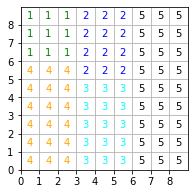

In [8]:
instance_number = 2
file_path = f"../instances/ins-{instance_number}.txt"

output = utils.read_output(file_path)
w = output[0][0]
n = output[1][0]
dims = np.array(output[2:])

print(sum(dims[:, WIDTH] * dims[:, HEIGHT]))

upperbound = sum(dims[:, 1])
l = max(dims[:,1])

s, v = vlsi_design(w, n, dims, l)
while(not s.check()==sat):
    print("Trying again with l=", l+1)
    l += 1
    s, v = vlsi_design(w, n, dims, l)



model = s.model()
sol = []
for x in range(w):
    sol.append([])
    for y in range(l):
        found_circuit = False
        for c in range(1, n + 1):
            if model.evaluate(v[x][y][c]):
                found_circuit = True
                sol[x].append(c)
        if not found_circuit:
            sol[x].append(0)

utils.visualize_w_color(sol, w, len(sol[0]), n)

In [6]:
w = 8
n = 4
dims = np.array([[3, 3], [3, 5], [5, 3], [5, 5]])

sol = vlsi_design(w, n, dims)
len(sol)
utils.display_sudoku(sol, w, len(sol[0]))

TypeError: vlsi_design() missing 1 required positional argument: 'upper_bound'

In [40]:
en = 0
to =0
tre = 0 
fire = 0
a = 0
b =0
c = 0


for elm in sol:
    en += elm.count(1)
    to += elm.count(2)
    tre += elm.count(3)
    fire += elm.count(4)
    a += elm.count(5)
    b += elm.count(6)
    c += elm.count(7)

print(en, to, tre, fire, a, b, c)
    

9 12 15 18 15 20 32


In [25]:
import utils

instance_number = 30
file_path = f"../instances/ins-{instance_number}.txt"

output = utils.read_output(file_path)
w = output[0][0]
n = output[1][0]
dims = output[2:]

[[37], [27], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]
